# Regression Week 3: Assessing Fit (polynomial regression)

In this notebook you will compare different regression models in order to assess which model fits best. We will be using polynomial regression as a means to examine this topic. In particular you will:
* Write a function to take an SArray and a degree and return an SFrame where each column is the SArray to a polynomial value up to the total degree e.g. degree = 3 then column 1 is the SArray column 2 is the SArray squared and column 3 is the SArray cubed
* Use matplotlib to visualize polynomial regressions
* Use matplotlib to visualize the same polynomial degree on different subsets of the data
* Use a validation set to select a polynomial degree
* Assess the final fit using test data

We will continue to use the House data from previous notebooks.

## Importing Libraries

In [28]:
import os
import zipfile
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

## Unzipping files with house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [29]:
# Put files in current direction into a list
files_list = [f for f in os.listdir('.') if os.path.isfile(f)]

In [30]:
# Filenames of unzipped files
unzip_files = ['kc_house_data.csv','wk3_kc_house_set_1_data.csv', 'wk3_kc_house_set_2_data.csv',
               'wk3_kc_house_set_3_data.csv', 'wk3_kc_house_set_4_data.csv', 'wk3_kc_house_test_data.csv',
               'wk3_kc_house_train_data.csv', 'wk3_kc_house_valid_data.csv']

In [31]:
# If upzipped file not in files_list, unzip the file
for filename in unzip_files:
    if filename not in files_list:
        zip_file = filename + '.zip'
        zip = zipfile.ZipFile(zip_file)
        zip.extractall()
        zip.close

## Basics of apply function for Pandas DataFrames

Next we're going to write a polynomial function that takes an SArray and a maximal degree and returns an SFrame with columns containing the SArray to all the powers up to the maximal degree.

The easiest way to apply a power to an SArray is to use the .apply() and lambda x: functions. 
For example to take the example array and compute the third power we can do as follows: (note running this cell the first time may take longer than expected since it loads graphlab)

In [32]:
tmp = pd.Series([1.0, 2.0, 3.0])
tmp_cubed = tmp.apply(lambda x: x**3) 
print tmp
print tmp_cubed

0    1
1    2
2    3
dtype: float64
0     1
1     8
2    27
dtype: float64


We can create an empty SFrame using graphlab.SFrame() and then add any columns to it with ex_sframe['column_name'] = value. For example we create an empty SFrame and make the column 'power_1' to be the first power of tmp (i.e. tmp itself).

In [33]:
ex_dframe = pd.DataFrame()
ex_dframe['power_1'] = tmp
print ex_dframe
print type(ex_dframe)

   power_1
0        1
1        2
2        3
<class 'pandas.core.frame.DataFrame'>


## Polynomial_dataframe function

Using the hints above complete the following function to create an SFrame consisting of the powers of an SArray up to a specific degree:

In [34]:
def polynomial_dataframe(feature, degree): # feature is pandas.Series type
    # assume that degree >= 1
    # initialize the dataframe:
    poly_dataframe = pd.DataFrame()
    # and set poly_dataframe['power_1'] equal to the passed feature
    poly_dataframe['power_1'] = feature
    
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        for power in range(2, degree+1):
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # assign poly_dataframe[name] to be feature^power; use apply(*)
            poly_dataframe[name] = poly_dataframe['power_1'].apply(lambda x: x**power) 
    return poly_dataframe

To test your function consider the smaller tmp variable and what you would expect the outcome of the following call:

In [35]:
tmp = pd.Series([1.0, 2.0, 3.0])
print polynomial_dataframe(tmp, 3)

   power_1  power_2  power_3
0        1        1        1
1        2        4        8
2        3        9       27


# Visualizing polynomial regression

Let's use matplotlib to visualize what a polynomial regression looks like on some real data. First, let's load house sales data

In [36]:
# Dictionary with the correct dtypes for the DataFrame columns
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 
              'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 
              'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 'lat':float, 
              'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

In [37]:
sales = pd.read_csv('kc_house_data.csv', dtype = dtype_dict)

As in Week 3, we will use the sqft_living variable. For plotting purposes (connecting the dots), you'll need to sort by the values of sqft_living. For houses with identical square footage, we break the tie by their prices.

In [38]:
sales = sales.sort_values(['sqft_living', 'price'])
sales[['sqft_living', 'price']].head()

,sqft_living,price
19452,290,142000
15381,370,276000
860,380,245000
18379,384,265000
4868,390,228000


Let's start with a degree 1 polynomial using 'sqft_living' (i.e. a line) to predict 'price' and plot what it looks like.

In [39]:
poly1_data = polynomial_dataframe(sales['sqft_living'], 1)
poly1_data['price'] = sales['price'] # add price to the data since it's the target
poly1_data.head()

,power_1,price
19452,290,142000
15381,370,276000
860,380,245000
18379,384,265000
4868,390,228000


NOTE: for all the models in this notebook use validation_set = None to ensure that all results are consistent across users.

In [40]:
#model1 = graphlab.linear_regression.create(poly1_data, target = 'price', features = ['power_1'], validation_set = None)
# Now, creating the feature matrix and output vector to perform linear regression with sklearn. Note: Must pass
# features for 
X_feat_model_1 = poly1_data[ ['power_1'] ]
y_output_model_1 = poly1_data['price']

In [41]:
model_1 = LinearRegression()
model_1.fit(X_feat_model_1, y_output_model_1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
# Let's look at the intercept and weight before we plot. Let's also define the line learned by linear regression
print model_1.intercept_
print model_1.coef_

-43580.7430945
[ 280.6235679]


In [43]:
# Let's also define the line learned by linear regression
x_model_1_lin_reg = np.arange(0,14000+1,1)
y_model_1_lin_reg = model_1.intercept_ + model_1.coef_[0]*x_model_1_lin_reg

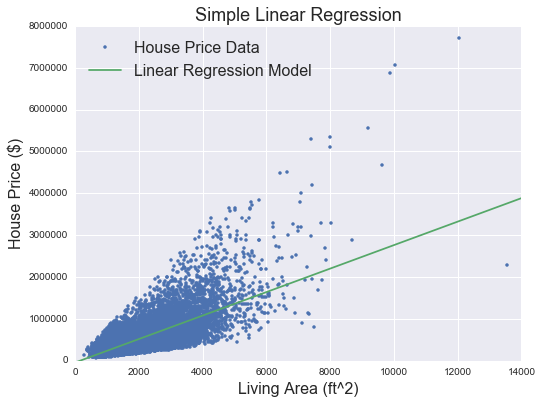

In [45]:
plt.figure(figsize=(8,6))
plt.plot(poly1_data['power_1'],poly1_data['price'],'.', label= 'House Price Data')
plt.hold(True)
plt.plot(x_model_1_lin_reg, y_model_1_lin_reg, '-' , label= 'Linear Regression Model')
plt.hold(False)
plt.legend(loc='upper left', fontsize=16)
plt.xlabel('Living Area (ft^2)', fontsize=16)
plt.ylabel('House Price ($)', fontsize=16)
plt.title('Simple Linear Regression', fontsize=18)
plt.axis([0.0, 14000.0, 0.0, 8000000.0])
plt.show()

We can see, not surprisingly, that the predicted values all fall on a line, specifically the one with slope 280 and intercept -43579. What if we wanted to plot a second degree polynomial?

In [ ]:
poly2_data = polynomial_sframe(sales['sqft_living'], 2)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = sales['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = my_features, validation_set = None)

In [ ]:
model2.get("coefficients")

In [ ]:
plt.plot(poly2_data['power_1'],poly2_data['price'],'.',
        poly2_data['power_1'], model2.predict(poly2_data),'-')

The resulting model looks like half a parabola. Try on your own to see what the cubic looks like:

Now try a 15th degree polynomial:

What do you think of the 15th degree polynomial? Do you think this is appropriate? If we were to change the data do you think you'd get pretty much the same curve? Let's take a look.

# Changing the data and re-learning

We're going to split the sales data into four subsets of roughly equal size. Then you will estimate a 15th degree polynomial model on all four subsets of the data. Print the coefficients (you should use .print_rows(num_rows = 16) to view all of them) and plot the resulting fit (as we did above). The quiz will ask you some questions about these results.

To split the sales data into four subsets, we perform the following steps:
* First split sales into 2 subsets with `.random_split(0.5, seed=0)`. 
* Next split the resulting subsets into 2 more subsets each. Use `.random_split(0.5, seed=0)`.

We set `seed=0` in these steps so that different users get consistent results.
You should end up with 4 subsets (`set_1`, `set_2`, `set_3`, `set_4`) of approximately equal size. 

Fit a 15th degree polynomial on set_1, set_2, set_3, and set_4 using sqft_living to predict prices. Print the coefficients and make a plot of the resulting model.

Some questions you will be asked on your quiz:

**Quiz Question: Is the sign (positive or negative) for power_15 the same in all four models?**

**Quiz Question: (True/False) the plotted fitted lines look the same in all four plots**

# Selecting a Polynomial Degree

Whenever we have a "magic" parameter like the degree of the polynomial there is one well-known way to select these parameters: validation set. (We will explore another approach in week 4).

We split the sales dataset 3-way into training set, test set, and validation set as follows:

* Split our sales data into 2 sets: `training_and_validation` and `testing`. Use `random_split(0.9, seed=1)`.
* Further split our training data into two sets: `training` and `validation`. Use `random_split(0.5, seed=1)`.

Again, we set `seed=1` to obtain consistent results for different users.

Next you should write a loop that does the following:
* For degree in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] (to get this in python type range(1, 15+1))
    * Build an SFrame of polynomial data of train_data['sqft_living'] at the current degree
    * hint: my_features = poly_data.column_names() gives you a list e.g. ['power_1', 'power_2', 'power_3'] which you might find useful for graphlab.linear_regression.create( features = my_features)
    * Add train_data['price'] to the polynomial SFrame
    * Learn a polynomial regression model to sqft vs price with that degree on TRAIN data
    * Compute the RSS on VALIDATION data (here you will want to use .predict()) for that degree and you will need to make a polynmial SFrame using validation data.
* Report which degree had the lowest RSS on validation data (remember python indexes from 0)

(Note you can turn off the print out of linear_regression.create() with verbose = False)

**Quiz Question: Which degree (1, 2, …, 15) had the lowest RSS on Validation data?**

Now that you have chosen the degree of your polynomial using validation data, compute the RSS of this model on TEST data. Report the RSS on your quiz.

**Quiz Question: what is the RSS on TEST data for the model with the degree selected from Validation data?**